In [1]:
%matplotlib inline



# Forward model EEG

Forward computation using the fsaverage.


In [ ]:
import os.path as op
import numpy as np
import mne
#from mne.datasets import sample
#data_path = sample.data_path()
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage

# FROM MEG EXAMPLE
# the raw file containing the channel location + types
    # sample_dir = op.join(data_path, 'MEG', 'sample',)
    # raw_fname = op.join(sample_dir, 'sample_audvis_raw.fif')
# The paths to Freesurfer reconstructions
    # subjects_dir = op.join(data_path, 'subjects')
    # subject = 'sample'


# FROM FSAVERAGE EXAMPLE
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

## Computing the forward operator

To compute a forward operator we need:

   - a ``-trans.fif`` file that contains the coregistration info.
   - a source space
   - the :term:`BEM` surfaces



## Compute and visualize BEM surfaces

The :term:`BEM` surfaces are the triangulations of the interfaces between
different tissues needed for forward computation. These surfaces are for
example the inner skull surface, the outer skull surface and the outer skin
surface, a.k.a. scalp surface.

Computing the BEM surfaces requires FreeSurfer and makes use of
the command-line tools `mne watershed_bem` or `mne flash_bem`, or
the related functions :func:`mne.bem.make_watershed_bem` or
:func:`mne.bem.make_flash_bem`.

Here we'll assume it's already computed. It takes a few minutes per subject.

For EEG we use 3 layers (inner skull, outer skull, and skin).

Let's look at these surfaces. The function :func:`mne.viz.plot_bem`
assumes that you have the ``bem`` folder of your subject's FreeSurfer
reconstruction, containing the necessary surface files. Here we use a smaller
than default subset of ``slices`` for speed.



Using surface: C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\bem\inner_skull.surf
Using surface: C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\bem\outer_skull.surf
Using surface: C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\bem\outer_skin.surf


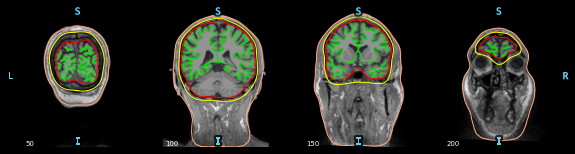

In [3]:
import matplotlib
matplotlib.use( 'tkagg' )

plot_bem_kwargs = dict(
    subject=subject, subjects_dir=subjects_dir,
    brain_surfaces='white', orientation='coronal',
    slices=[50, 100, 150, 200])

mne.viz.plot_bem(**plot_bem_kwargs)

### Load the data

We use here EEG data from the BCI dataset.

<div class="alert alert-info"><h4>Note</h4><p>See `plot_montage` to view all the standard EEG montages
          available in MNE-Python.</p></div>

### Visualizing the coregistration
The coregistration is the operation that allows to position the head and the sensors in a common coordinate system. In the MNE software the transformation to align the head and the sensors in stored in a so-called trans file. It is a FIF file that ends with -trans.fif. It can be obtained with :func:mne.gui.coregistration (or its convenient command line equivalent mne coreg), or mrilab if you’re using a Neuromag system.
Here we assume the coregistration is done, so we just visually check the alignment with the following code.

In [6]:
# The transformation file is build in in fsaverage

#info = mne.io.read_info(raw_fname)

raw_fname, = eegbci.load_data(subject=1, runs=[6])
raw = mne.io.read_raw_edf(raw_fname, preload=True)

# Clean channel names to be able to use a standard 1005 montage
new_names = dict(
    (ch_name,
     ch_name.rstrip('.').upper().replace('Z', 'z').replace('FP', 'Fp'))
    for ch_name in raw.ch_names)
raw.rename_channels(new_names)

# Read and set the EEG electrode locations, which are already in fsaverage's
# space (MNI space) for standard_1020:
montage = mne.channels.make_standard_montage('standard_1005')
raw.set_montage(montage)
raw.set_eeg_reference(projection=True)  # needed for inverse modeling

# Check that the locations of EEG electrodes is correct with respect to MRI
mne.viz.plot_alignment(
    raw.info, src=src, eeg=['original', 'projected'], trans=trans,
    show_axes=True, mri_fiducials=True, dig='fiducials')

Extracting EDF parameters from C:\Users\janak\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Reading C:\Users\janak\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-ico-5-src.fif...
Using outer_skin.surf for head surface.
Channel types::	eeg: 64
Projecting sensors to the head surface



## Compute Source Space

The source space defines the position and orientation of the candidate source
locations. There are two types of source spaces:

- **surface-based** source space when the candidates are confined to a
  surface.

- **volumetric or discrete** source space when the candidates are discrete,
  arbitrarily located source points bounded by the surface.

**Surface-based** source space is computed using
:func:`mne.setup_source_space`, while **volumetric** source space is computed
using :func:`mne.setup_volume_source_space`.

We will now compute a surface-based source space with an ``'oct4'``
resolution. See `setting_up_source_space` for details on source space
definition and spacing parameter.

<div class="alert alert-danger"><h4>Warning</h4><p>``'oct4'`` is used here just for speed, for real analyses the recommended
    spacing is ``'oct6'``.</p></div>



In [7]:
src = mne.setup_source_space(subject, spacing='oct4', add_dist='patch',
                             subjects_dir=subjects_dir)
print(src)

Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\janak\mne_data\MNE-fsaverage-data
Subject      = fsaverage
Surface      = white
Octahedron subdivision grade 4

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading C:\Users\janak\mne_data\MNE-fsaverage-data\fsaverage\surf\lh.white...
Mapping lh fsaverage -> oct (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\janak\mne_data\MNE-fsaverage-data\fsaverage\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 258/163842 selected to source space (oct = 4)

Loading C:\Users\janak\mne_data\MNE-fsaverage-data\fsaverage\surf\rh.white...
Mapping rh fsaverage -> oct (4) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\janak\mne_data\MNE-fsaverage-data\fsaverage\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 258/163842 selected to source

The surface based source space ``src`` contains two parts, one for the left
hemisphere (258 locations) and one for the right hemisphere (258
locations). Sources can be visualized on top of the BEM surfaces in purple.



Using surface: C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\bem\inner_skull.surf
Using surface: C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\bem\outer_skull.surf
Using surface: C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\bem\outer_skin.surf


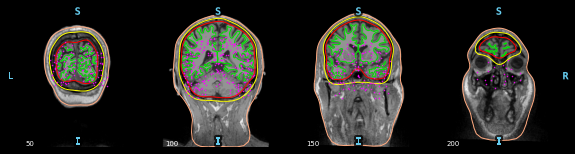

In [8]:
mne.viz.plot_bem(src=src, **plot_bem_kwargs)

To compute a volume based source space defined with a grid of candidate
dipoles inside a sphere of radius 90mm centered at (0.0, 0.0, 40.0) mm
you can use the following code.
Obviously here, the sphere is not perfect. It is not restricted to the
brain and it can miss some parts of the cortex.



Sphere                : origin at (0.0 0.0 40.0) mm
              radius  : 90.0 mm
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\mri\T1.mgz

Reading C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\mri\T1.mgz...

Setting up the sphere...
Surface CM = (   0.0    0.0   40.0) mm
Surface fits inside a sphere with radius   90.0 mm
Surface extent:
    x =  -90.0 ...   90.0 mm
    y =  -90.0 ...   90.0 mm
    z =  -50.0 ...  130.0 mm
Grid extent:
    x =  -95.0 ...   95.0 mm
    y =  -95.0 ...   95.0 mm
    z =  -50.0 ...  135.0 mm
57798 sources before omitting any.
24365 sources after omitting infeasible sources not within 0.0 - 90.0 mm.
20377 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Adjusting the neighborhood info.
Source space : MRI voxel -> MRI (surface RAS)
     0.005000  0.000000  0.000000     -95.00 mm
     0.000000  0.005000  

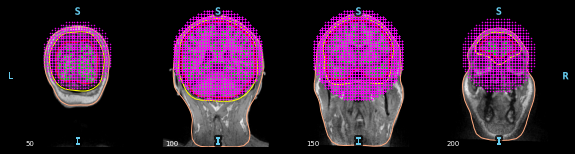

In [10]:
sphere = (0.0, 0.0, 0.04, 0.09)
vol_src = mne.setup_volume_source_space(
    subject, subjects_dir=subjects_dir, sphere=sphere, sphere_units='m',
    add_interpolator=False)  # just for speed!
print(vol_src)

mne.viz.plot_bem(src=vol_src, **plot_bem_kwargs)

To compute a volume based source space defined with a grid of candidate
dipoles inside the brain (requires the :term:`BEM` surfaces) you can use the
following.



Boundary surface file : C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\bem\inner_skull.surf
grid                  : 5.0 mm
mindist               : 5.0 mm
MRI volume            : C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\mri\T1.mgz

Reading C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\mri\T1.mgz...

Loaded bounding surface from C:\Users\janak\mne_data\MNE-sample-data\subjects\sample\bem\inner_skull.surf (2562 nodes)
Surface CM = (   0.7  -10.0   44.3) mm
Surface fits inside a sphere with radius   91.8 mm
Surface extent:
    x =  -66.7 ...   68.8 mm
    y =  -88.0 ...   79.0 mm
    z =  -44.5 ...  105.8 mm
Grid extent:
    x =  -70.0 ...   70.0 mm
    y =  -90.0 ...   80.0 mm
    z =  -45.0 ...  110.0 mm
32480 sources before omitting any.
22941 sources after omitting infeasible sources not within 0.0 - 91.8 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking 

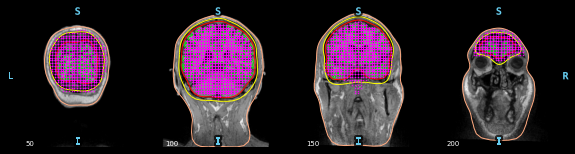

In [11]:
surface = op.join(subjects_dir, subject, 'bem', 'inner_skull.surf')
vol_src = mne.setup_volume_source_space(
    subject, subjects_dir=subjects_dir, surface=surface,
    add_interpolator=False)  # Just for speed!
print(vol_src)

mne.viz.plot_bem(src=vol_src, **plot_bem_kwargs)

<div class="alert alert-info"><h4>Note</h4><p>Some sources may appear to be outside the BEM inner skull contour.
          This is because the ``slices`` are decimated for plotting here.
          Each slice in the figure actually represents several MRI slices,
          but only the MRI voxels and BEM boundaries for a single (midpoint
          of the given slice range) slice are shown, whereas the source space
          points plotted on that midpoint slice consist of all points
          for which that slice (out of all slices shown) was the closest.</p></div>

Now let's see how to view all sources in 3D.



In [12]:
fig = mne.viz.plot_alignment(subject=subject, subjects_dir=subjects_dir,
                             surfaces='white', coord_frame='mri',
                             src=src)

mne.viz.set_3d_view(fig, azimuth=173.78, elevation=101.75,
                    distance=0.30, focalpoint=(-0.03, -0.01, 0.03))


## Compute forward solution

We can now compute the forward solution.
To reduce computation we'll just compute a single layer BEM (just inner
skull) that can then be used for MEG (not EEG).
We specify if we want a one-layer or a three-layer BEM using the
``conductivity`` parameter.
The BEM solution requires a BEM model which describes the geometry
of the head the conductivities of the different tissues.



In [13]:
# conductivity = (0.3,)  # for single layer
conductivity = (0.3, 0.006, 0.3)  # for three layers
model = mne.make_bem_model(subject=subject, ico=4,
                           conductivity=conductivity,
                           subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is  -0.21 -19.38  -0.23 mm
outer skull CM is  -0.19 -19.34  -0.49 mm
inner skull CM is  -0.53 -21.10   6.21 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    1.6 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    5.4 mm
Surfaces passed the basic topology checks.
Complete.

Approximation method : Linear collocation

Three-layer model surfaces loaded.
Computing the linear collocation s

Note that the :term:`BEM` does not involve any use of the trans file. The BEM
only depends on the head geometry and conductivities.
It is therefore independent from the MEG data and the head position.

Let's now compute the forward operator, commonly referred to as the
gain or leadfield matrix.
See :func:`mne.make_forward_solution` for details on the meaning of each
parameter.



In [10]:
fwd = mne.make_forward_solution(raw.info, trans=trans, src=src, bem=bem,
                                meg=False, eeg=True, mindist=5.0, n_jobs=1,
                                verbose=True)
# raw.info
print(fwd)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=258>, <surface (rh), n_vertices=163842, n_used=258>] MRI (surface RAS) coords, subject 'fsaverage', ~28.8 MB>
MRI -> head transform : C:\Users\janak\anaconda3\envs\mne\lib\site-packages\mne\data\fsaverage\fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : C:\Users\janak\mne_data\MNE-fsaverage-data\fsaverage\bem\fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 516 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  64 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM model us

<div class="alert alert-danger"><h4>Warning</h4><p>Forward computation can remove vertices that are too close to (or outside)
   the inner skull surface. For example, here we have gone from 516 to 474
   vertices in use. For many functions, such as
   :func:`mne.compute_source_morph`, it is important to pass ``fwd['src']``
   or ``inv['src']`` so that this removal is adequately accounted for.</p></div>



In [15]:
print(f'Before: {src}')
print(f'After:  {fwd["src"]}')

Before: <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=258>, <surface (rh), n_vertices=156866, n_used=258>] MRI (surface RAS) coords, subject 'sample', ~27.5 MB>
After:  <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=235>, <surface (rh), n_vertices=156866, n_used=239>] head coords, subject 'sample', ~27.5 MB>


We can explore the content of ``fwd`` to access the numpy array that contains
the gain matrix.



In [11]:
leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

Leadfield size : 64 sensors x 1548 dipoles


To extract the numpy array containing the forward operator corresponding to
the source space ``fwd['src']`` with cortical orientation constraint
we can use the following:



In [17]:
fwd_fixed = mne.convert_forward_solution(fwd, surf_ori=True, force_fixed=True,  #probably not needed for EEG,
                                         use_cps=True)
leadfield = fwd_fixed['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)

    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Leadfield size : 306 sensors x 474 dipoles


This is equivalent to the following code that explicitly applies the
forward operator to a source estimate composed of the identity operator
(which we omit here because it uses a lot of memory)::

    >>> import numpy as np
    >>> n_dipoles = leadfield.shape[1]
    >>> vertices = [src_hemi['vertno'] for src_hemi in fwd_fixed['src']]
    >>> stc = mne.SourceEstimate(1e-9 * np.eye(n_dipoles), vertices)
    >>> leadfield = mne.apply_forward(fwd_fixed, stc, info).data / 1e-9

To save to disk a forward solution you can use
:func:`mne.write_forward_solution` and to read it back from disk
:func:`mne.read_forward_solution`. Don't forget that FIF files containing
forward solution should end with :file:`-fwd.fif`.

To get a fixed-orientation forward solution, use
:func:`mne.convert_forward_solution` to convert the free-orientation
solution to (surface-oriented) fixed orientation.
